Importing libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler


In [2]:
df=pd.read_excel('sifarisler.xlsx') # importing dataset


In [21]:
df.rename(columns={'Customers': 'Id', 'tarix': 'Dates' ,'Satis (azn)': 'Sales($)'}, inplace=True) # Changing the name of columns of the dataset since its in AZN language.


In [22]:
df.head() # represents first 5 rows of the data set

,Id,Dates,Sales($)
0,556227575,2019-05-18,15.0
1,557660657,2019-05-18,30.0
2,556724772,2019-05-18,23.0
3,505244006,2019-05-18,28.0
4,546450050,2019-05-18,26.0


In [5]:
df.info() # used to get information of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Customers  1990 non-null   object        
 1   Dates      1999 non-null   datetime64[ns]
 2   Sales($)   1990 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 47.0+ KB


Data Cleaning : Checking for any null values

In [23]:
df.isnull() # used to check null values

,Id,Dates,Sales($)
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
1994,False,False,False
1995,False,False,False
1996,False,False,False
1997,False,False,False


In [7]:
df.dropna(inplace=True) #used to remove and null or NaN values

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1981 entries, 0 to 1998
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Customers  1981 non-null   object        
 1   Dates      1981 non-null   datetime64[ns]
 2   Sales($)   1981 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 61.9+ KB


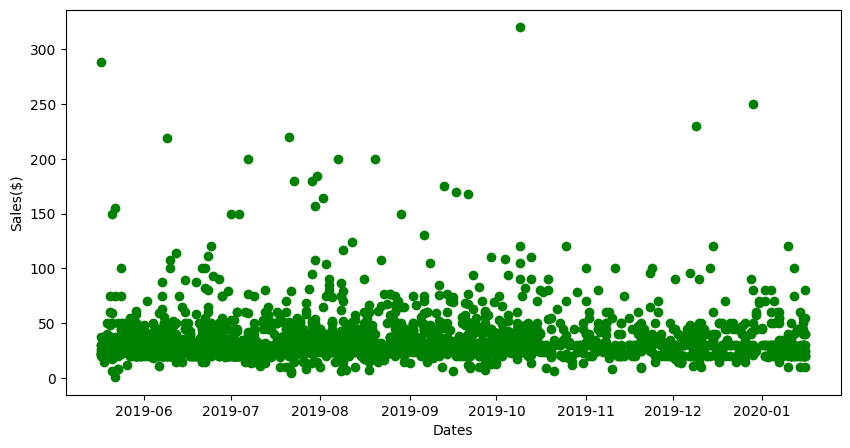

In [57]:
plt.figure(figsize=(10, 5))
plt.scatter(df['Dates'], df['Sales($)'], c='green')  # Set the color to green
plt.xlabel('Dates')
plt.ylabel('Sales($)')
plt.show()

In [24]:
df.Id.nunique() # looking number of unique customers

1546

In [25]:
cst=pd.DataFrame(df['Id'].unique(),columns=['uid']).astype('str')
cst

,uid
0,556227575
1,557660657
2,556724772
3,505244006
4,546450050
...,...
1541,556402456
1542,555552227
1543,552007006
1544,552264462


 On Recency : We'll calculate recency for each unique 'Customers' in the DataFrame and store the results in a new DataFrame called df_rcn.

In [26]:
df_rcn=df.groupby('Id')['Dates'].max().reset_index()
df_rcn['recency']=(df_rcn['Dates'].max() - df_rcn['Dates']).dt.days
df_rcn.drop(columns=['Dates'], inplace=True)
df_rcn

,Id,recency
0,224,167
1,45002262,200
2,50407770,219
3,54272224,188
4,55252426,188
...,...,...
1541,0776262626,44
1542,0776262726,217
1543,0777656656,205
1544,Emin,240


On Frequency : We'll calculate the "frequency" of occurrences for each unique 'id' in the DataFrame and store the results in a new DataFrame called df_frq. 

In [35]:
df_frq=df.groupby('Id')['Dates'].count().reset_index()
df_frq['frequency']=df_frq['Dates']
df_frq.drop(columns=['Dates'], inplace=True)
df_frq

,Id,frequency
0,224,2
1,45002262,1
2,50407770,1
3,54272224,1
4,55252426,1
...,...,...
1541,0776262626,1
1542,0776262726,1
1543,0777656656,1
1544,Emin,1


On Monetary : Usually, Monetary is accepted as the sum of all purchase(or other types of) values, but in this case, it was considered and calculated as average.

In [29]:
df_rvn=df.groupby('Id')['Sales($)'].mean().reset_index() # on average sale(revenue) for each customer
df_rvn.rename(columns={'Sales($)':'mean_rev'}, inplace=True)
df_rvn

,Id,mean_rev
0,224,86.0
1,45002262,36.0
2,50407770,30.0
3,54272224,14.0
4,55252426,30.0
...,...,...
1541,0776262626,40.0
1542,0776262726,30.0
1543,0777656656,28.0
1544,Emin,6.0


Merging dataset to RFM

In [31]:
rfm=df_rcn.merge(df_frq, left_on='Id', right_on='Id').merge(df_rvn, left_on='Id', right_on='Id')
rfm.head()

,Id,recency,frequency,mean_rev
0,224,167,2,86.0
1,45002262,200,1,36.0
2,50407770,219,1,30.0
3,54272224,188,1,14.0
4,55252426,188,1,30.0


Data Normalization (Scaling)

In [33]:
md_rfm=rfm[['recency','frequency','mean_rev']]
rb=RobustScaler()
rb.fit(md_rfm)
md_rfm=pd.DataFrame(rb.transform(md_rfm), columns=['recency','frequency','mean_rev'])
md_rfm['Id']=rfm.Id
md_rfm.head()

,recency,frequency,mean_rev,Id
0,0.188119,1.0,3.500,224
1,0.514851,0.0,0.375,45002262
2,0.702970,0.0,0.000,50407770
3,0.396040,0.0,-1.000,54272224
4,0.396040,0.0,0.000,55252426


I aim to divide customers into four segmentation: Loyal customers, Can't lose them, Lost customers, New customers

Modelling

In [36]:
kms=KMeans(n_clusters=4)
kms.fit(md_rfm[['recency','frequency','mean_rev']])
clustered=pd.DataFrame(kms.predict(md_rfm[['recency','frequency','mean_rev']]), columns=['Segmented_group'])
clustered=clustered.merge(md_rfm, left_index=True, right_index=True)
clustered

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Segmented_group,recency,frequency,mean_rev,Id
0,1,0.188119,1.0,3.500,224
1,0,0.514851,0.0,0.375,45002262
2,0,0.702970,0.0,0.000,50407770
3,0,0.396040,0.0,-1.000,54272224
4,0,0.396040,0.0,0.000,55252426
...,...,...,...,...,...
1541,1,-1.029703,0.0,0.625,0776262626
1542,0,0.683168,0.0,0.000,0776262726
1543,0,0.564356,0.0,-0.125,0777656656
1544,0,0.910891,0.0,-1.500,Emin


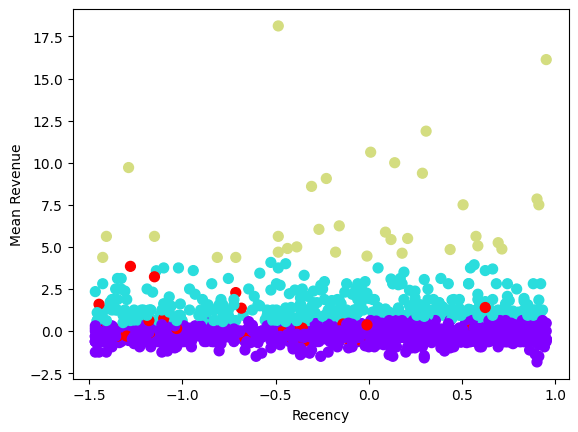

In [40]:
plt.scatter(clustered['recency'], clustered['mean_rev'], c=clustered['Segmented_group'], s=50, cmap='rainbow')
plt.xlabel('Recency')
plt.ylabel('Mean Revenue')
plt.show()

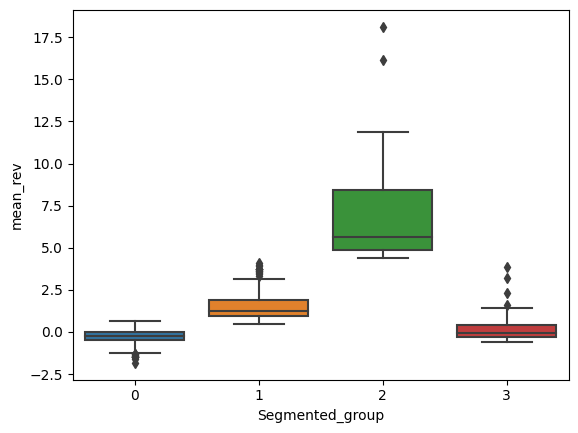

In [48]:
sns.boxplot(x= 'Segmented_group',y='mean_rev', data=clustered)
plt.show()


It can an be seen, 2-nd segmentation is a too wealthy group of customers, therefore "Can't lose them"

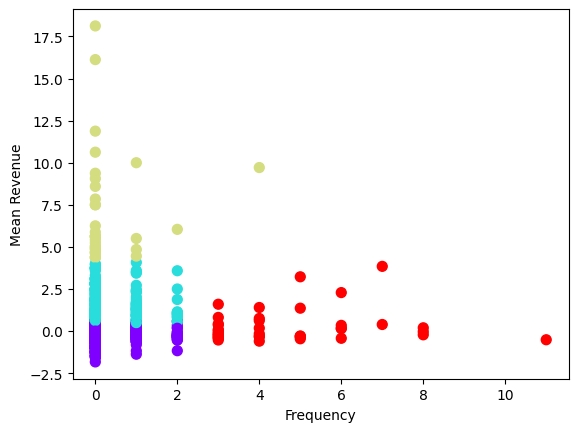

In [49]:
plt.scatter(clustered['frequency'], clustered['mean_rev'], c=clustered['Segmented_group'], s=50, cmap='rainbow')
plt.xlabel('Frequency')
plt.ylabel('Mean Revenue')
plt.show()

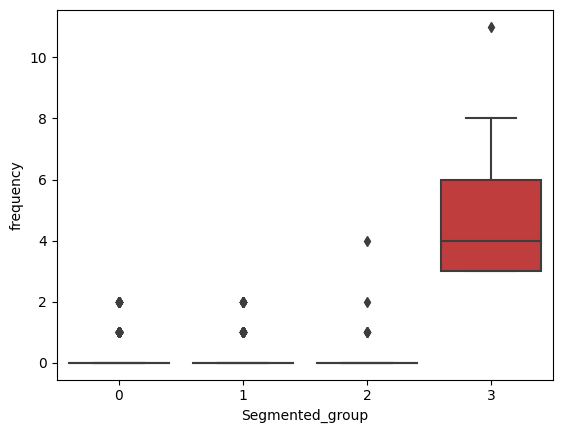

In [53]:
sns.boxplot(x='Segmented_group', y='frequency',data=clustered)
plt.show()

3-rd segmentation holds those customers who most frequently do purchase, so that is "Loyal Customers"

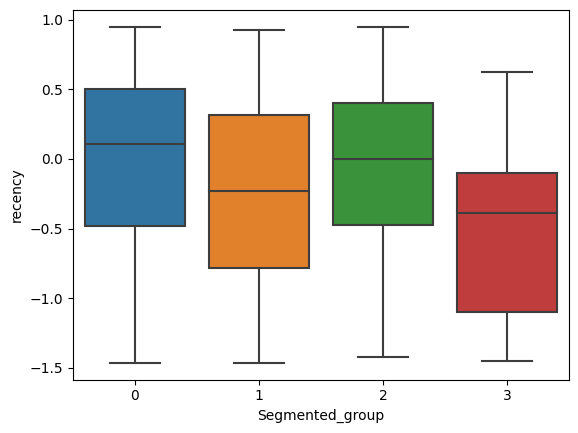

In [55]:
sns.boxplot(x='Segmented_group', y='recency',data=clustered)
plt.show()
#sns.boxenplot('Segmented_group','recency',data=clustured)

3- Loyal customers, 1- Lost customers, 2- Can't lose them, 0- New customers

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


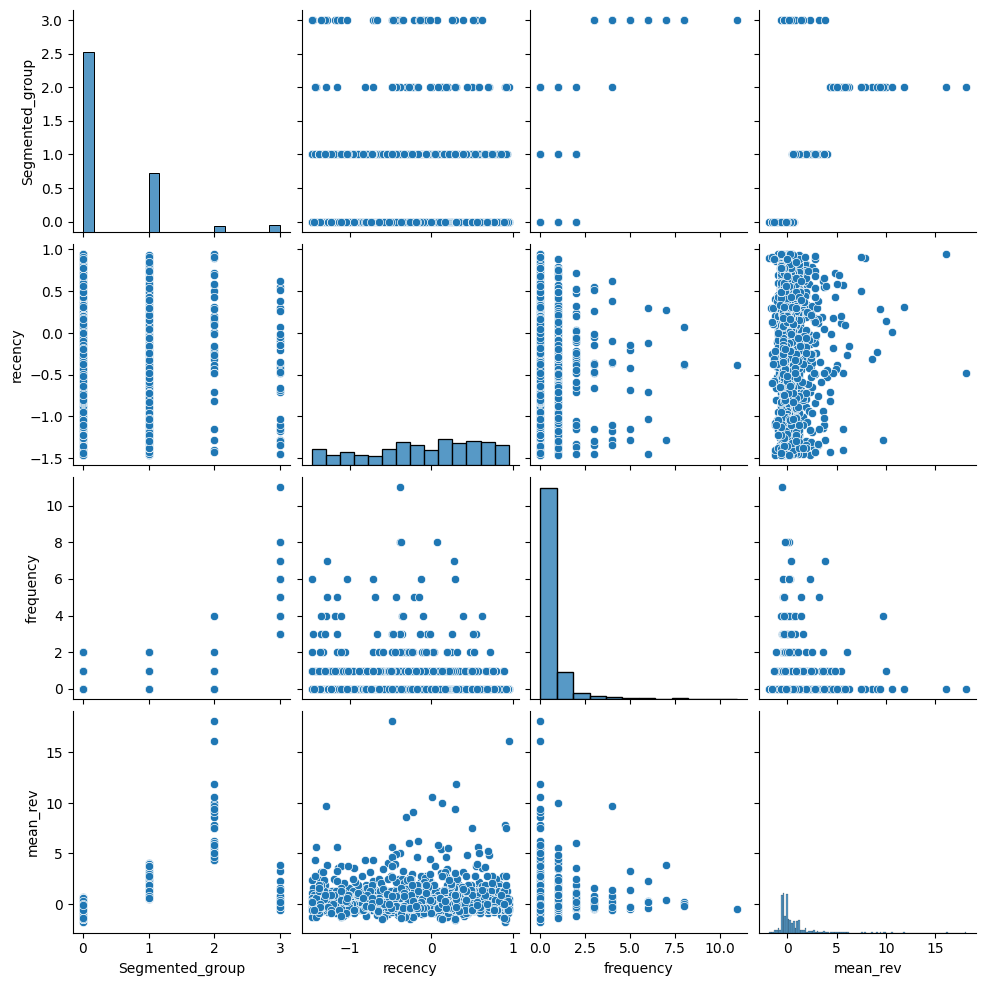

In [56]:
sns.pairplot(clustered)
plt.show()

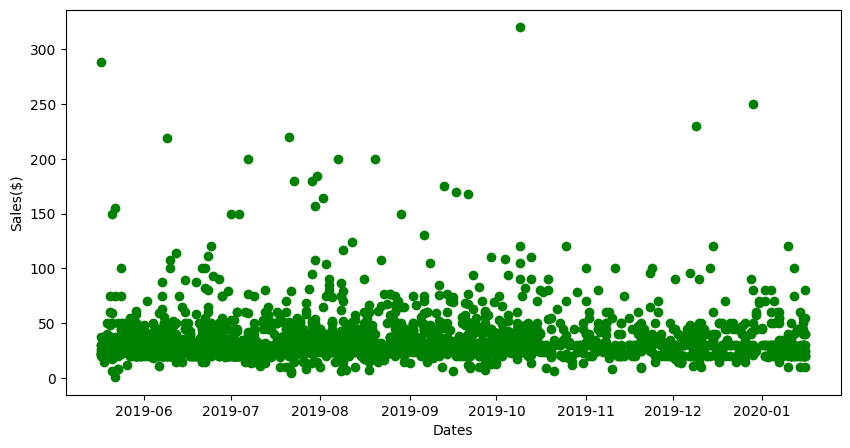